<h2 style="color:blue" align="center">CNN for Classification on CIFAR</h2>

#### Import the necessary libraries

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import Callback, CSVLogger 

#### Load and split the dataset into training and testing set

CIFAR 10

In [2]:
(X_train,y_train),(X_test,y_test) = keras.datasets.cifar10.load_data()

CIFAR 100

In [3]:
#(X_train,y_train),(X_test,y_test) = keras.datasets.cifar100.load_data()

#### Normalize the input dataset

In [4]:
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

In [5]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

#### Define Plain CNN model with two convolution layers

In [6]:
python_random.seed(3)
np.random.seed(7)
tf.random.set_seed(13)
opti_name = ''

def get_model(): 
    model = Sequential([ 
        # CNN layers
        Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(32,32,3)),
        MaxPooling2D((2,2)),
        
        Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
        MaxPooling2D((2,2)),
        
        # Dense layer
        Flatten(),
        Dense(256, activation = 'relu'), 
        Dense(128, activation = 'relu'), 
        # CIFAR 10
        Dense(10, activation = 'softmax')
        # CIFAR 100
        #Dense(100, activation = 'softmax')
    ]) 
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.01)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.6)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.6, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.6)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax' 
    
    model.compile(
        optimizer = opti,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [7]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):   
    # Training stop criteria
    stop_at = 0.99
    
    def on_epoch_end(self, epoch, logs={}):
        global generic_best
        acc = round(logs.get('accuracy'), 4)  
        
        if epoch == 0:
            generic_best = acc             
        
        if epoch > 0 and acc > generic_best :
            generic_best = acc  
            
        if(acc > self.stop_at):  
            self.model.stop_training = True 

For HM based optimizer model

In [8]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0 
    r = 1
    # r=0 no HM based, r=1 HM based
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  

    def on_epoch_end(self, epoch, logs={}):
        # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 

        current_weights = model_hm.get_weights() 
        current_weights = np.array(current_weights, dtype=object)       

        tensor1 = tf.convert_to_tensor(self.initial_weights[4])
        tensor2 = tf.convert_to_tensor(current_weights[4])
        current_weights[4] = self.call_hm(tensor1, tensor2)

        tensor1 = tf.convert_to_tensor(self.initial_weights[6])
        tensor2 = tf.convert_to_tensor(current_weights[6])
        current_weights[6] = self.call_hm(tensor1, tensor2) 

        tensor1 = tf.convert_to_tensor(self.initial_weights[8])
        tensor2 = tf.convert_to_tensor(current_weights[8])
        current_weights[8] = self.call_hm(tensor1, tensor2)        
               
        # Updating the model with new weights   
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
        # Stopping criteria
        if(round(logs.get('accuracy'), 4) > generic_best): 
            self.model.stop_training = True
        
    def apply_hm(self, v1, v2):     
        if v1==0 or v2==0:
            return v2
        elif v1>0 and v2>0:
            hm = 2*v1*v2/(v1+v2)
            min1 = min(v1,v2)
            diff = abs(hm-min1) * self.r
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        elif v1<0 and v2<0:
            hm = 2*v1*v2/(v1+v2)
            max1 = max(v1,v2)
            diff = abs(hm-max1) * self.r
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        else:
            return v2  

To record loss and accuracy in CSV file

In [9]:
logger_generic_model = CSVLogger('1.Generic_Plain_CNN_CIFAR.csv', append = False, separator = ',')
logger_hm_model = CSVLogger('1.HM_Plain_CNN_CIFAR.csv ', append = False, separator = ',')

#### Training

Get a model to assign same weights to model with and without HM

In [10]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 50

Generic opimizer model

In [11]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time()
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size = X.train.shape[0]) 
et = time.time()
elapsed_time = round(et - st, 4)
print('Execution time:', elapsed_time, 'seconds')
print('\nGeneric optimizer best Accuracy is :', generic_best)

Epoch 1/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3878 - accuracy: 0.4986
Epoch 2/50
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0087 - accuracy: 0.6454
Epoch 3/50
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8340 - accuracy: 0.7067
Epoch 4/50
1417/1563 [==========================>...] - ETA: 3s - loss: 0.6994 - accuracy: 0.7557

KeyboardInterrupt: 

HM based optimizer model

In [12]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size = X.train.shape[0]) 
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Epoch 1/50
1563/1563 [==============================] - 35s 22ms/step - loss: 1.3878 - accuracy: 0.4986
Epoch 2/50
1563/1563 [==============================] - 33s 21ms/step - loss: 1.0048 - accuracy: 0.6483
Epoch 3/50
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8250 - accuracy: 0.7108
Execution time: 101.3926374912262 seconds


Model summary

In [13]:
model_hm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 256)              

#### Generic optimizer vs HM-based optimizer

In [14]:
df1 = pd.read_csv("1.Generic_Plain_CNN_CIFAR.csv")
df2 = pd.read_csv("1.HM_Plain_CNN_CIFAR.csv ")

Loss

ValueError: x and y must have same first dimension, but have shapes (50,) and (3,)

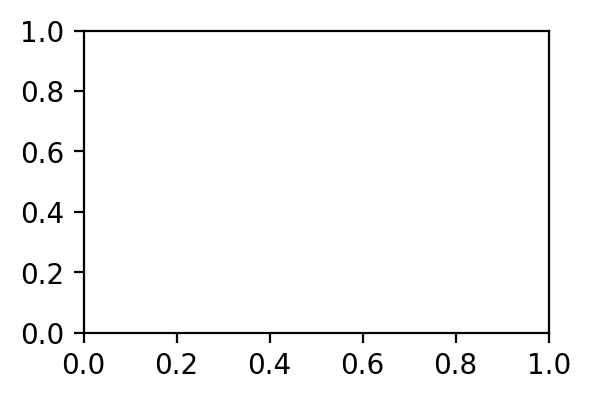

In [15]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['accuracy'] 
y2 = df2['accuracy']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Accuracy' , fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xlabel('Epoch', fontdict = {'fontname':'Times New Roman', 'fontsize':8})
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 7, fontname = 'Times New Roman')
plt.yticks(fontsize = 7, fontname = 'Times New Roman')
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

Accuracy

ValueError: x and y must have same first dimension, but have shapes (50,) and (3,)

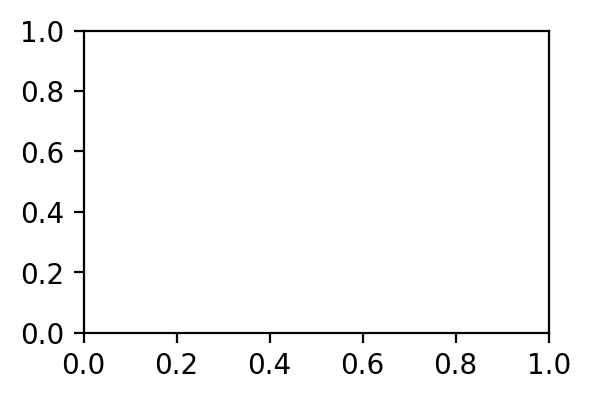

In [16]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xlabel('Epoch', fontdict = {'fontname':'Times New Roman', 'fontsize':8})
#plt.title("MAE", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 7, fontname = 'Times New Roman')
plt.yticks(fontsize = 7, fontname = 'Times New Roman')
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

###### Testing the model

Generic opimizer model

In [17]:
model_wihtout_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.8926 - accuracy: 0.6945


[0.8926313519477844, 0.6945000290870667]

HM based optimizer model

In [18]:
model_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.9717 - accuracy: 0.6863


[0.9716771245002747, 0.6862999796867371]